In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
from study import V27, unstable
from trajectory import Trajectory

In [18]:
from mmctools.helper_functions import fit_power_law_alpha, power_spectral_density

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
case = {
    'Kelsey': unstable(
        casedir='Shaler_DWMT-LES/WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable',
        prefix='NREL_SHALER_DWMT_LES_190910',
        suffix='_Unstable',
        turbine=V27,
    ),
    'Mithu': unstable(
        casedir='Debnath_LES/WAKEBENCH-NREL_DEBNATH_LES/unstable',
        prefix='NREL_DEBNATH_LES_20191021',
        turbine=V27,
    ),
}

## compare inflows

In [6]:
zprofile, Uprofile = {},{}
for key,results in case.items():
    data = np.load(os.path.join(results.casedir,'inflow.npz'))
    Uprofile[key] = data['U']
    zprofile[key] = data['z']

In [7]:
Uref, alpha = {},{}
for key in case.keys():
    interpfun = interp1d(zprofile[key], Uprofile[key])
    Uhub = interpfun(case[key].turbine.zhub)
    Uref[key] = np.nanmean(Uhub)
    alpha[key],R2 = fit_power_law_alpha(zprofile[key], np.nanmean(Uprofile[key],axis=0),
                                     zref=case[key].turbine.zhub, Uref=Uref[key])

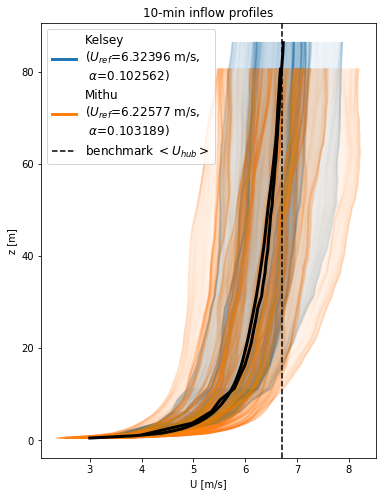

In [8]:
fig,ax = plt.subplots(figsize=(6,8))
for i,key in enumerate(case.keys()):
    color = colors[i]
    for itime in range(0,len(Uprofile[key])):
        ax.plot(Uprofile[key][itime,:], zprofile[key], color=color, alpha=0.03)
for i,key in enumerate(case.keys()):
    color = colors[i]
    ax.plot([], [], color=color, lw=3, label=key+'\n'
                                             + r'($U_{ref}$'+'={:g} m/s,'.format(Uref[key])+'\n'
                                             + r' $\alpha$={:g})'.format(alpha[key]))
    ax.plot(np.nanmean(Uprofile[key],axis=0), zprofile[key], color='k', lw=3)
ax.axvline(case[key].Uref, color='k', ls='--', label=r'benchmark $<U_{hub}>$')
ax.legend(loc='upper left',fontsize='large')
ax.set_xlabel('U [m/s]')
ax.set_ylabel('z [m]')
ax.set_title('10-min inflow profiles')
fig.savefig('inflow_profile_comparison.png',bbox_inches='tight')

## compare wake motion

In [9]:
traj = {
    key: Trajectory(results,'2D-Gaussian_fit')
    for key,results in case.items()
}

Shaler_DWMT-LES/WAKEBENCH-NREL_SHALER_DWMT-LES/Phase 2/unstable/2D-Gaussian_fit/trajectory_3D.csv
Debnath_LES/WAKEBENCH-NREL_DEBNATH_LES/unstable/2D-Gaussian_fit/trajectory_3D.csv


In [12]:
def moving_median(series, window):
    return series.rolling(window, center=True).median()

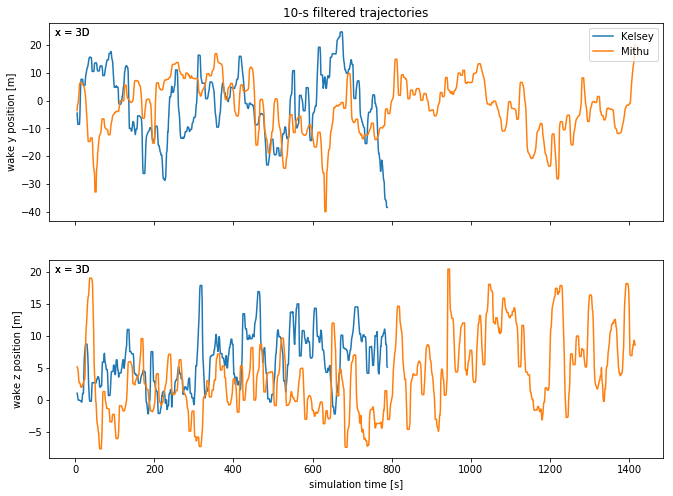

In [14]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
for key,results in traj.items():
    results.plot_wake_hist('y',fig=fig,ax=ax[0],label=key,
                           applyfilter=lambda hist: moving_median(hist,10))
    results.plot_wake_hist('z',fig=fig,ax=ax[1],
                           applyfilter=lambda hist: moving_median(hist,10))
    ax[0].set_ylabel('wake y position [m]')
    ax[1].set_ylabel('wake z position [m]')
    ax[-1].set_xlabel('simulation time [s]')
    ax[0].legend(loc='upper right')
ax[0].set_title('10-s filtered trajectories')
fig.savefig('trajectory_comparison.png',bbox_inches='tight')

Kelsey 13.233333333333333 min
Mithu 23.666666666666668 min


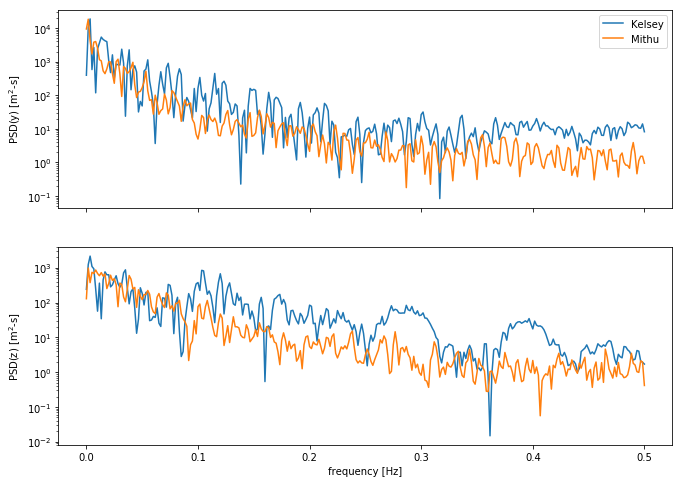

In [37]:
xdist = 81.0
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(11,8))
for key,results in traj.items():
    df = results.df.xs(xdist,level='x')
    print(key,len(df)/60,'min')
#     df_detrended = df.reset_index()
#     df_detrended['t'] = pd.to_timedelta(df_detrended['t'], unit='s')
#     df_detrended.set_index('t', inplace=True)
#     df_detrended = df_detrended - df_detrended.rolling('10min').mean()
#     PSD = power_spectral_density(df_detrended, detrend=None)
    PSD = power_spectral_density(df, detrend='linear')
    ax[0].semilogy(PSD.index, PSD['y'], label=key)
    ax[1].semilogy(PSD.index, PSD['z'], label=key)
    ax[0].set_ylabel(r'PSD(y) [m$^2$-s]')
    ax[1].set_ylabel(r'PSD(z) [m$^2$-s]')
    ax[-1].set_xlabel('frequency [Hz]')
    ax[0].legend(loc='upper right')
fig.savefig('trajectory_spectra_comparison.png',bbox_inches='tight')